# Project Purpose: 

Forecast Gold Price and Interpret by LIME and SHAP

packages install below:

In [ ]:
# 每次重启 runtime 时，跑一次 install 就够了
!pip install -U xgboost
!pip install lime shap

     |████████████████████████████████| 193.7 MB 33 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 275 kB 5.1 MB/s 
     |████████████████████████████████| 564 kB 40.8 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=a438ebac2af1e5f6d408f49ed0ca69790c19bf4524d85445c61b15f62a5c2a32
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


# 1. Synthetic Dataset Creation & Model train and Test

In [ ]:
# 8 features: Gold, Silver, Dollar Index, Platinum, Palladium, Economics Uncertainty Index, GPR index, Inflation

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn import metrics
from google.colab import drive
drive.mount('/content/drive')

import os
path="/content/drive/My Drive/Final Project_CS AI Visual/census/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_ = pd.read_csv(filepath_or_buffer= path+"names.csv", header=None)
columns = np.array(df_.iloc[:,0])

In [ ]:
df_census = pd.read_csv(filepath_or_buffer= path+"census-income.csv", names=columns)
#df_census.info()

In [ ]:
def convert_to_float(df, column):
  temp_lst=[]
  for ele in df[column]:
    temp_lst.append(float(ele))
  return temp_lst

df = pd.DataFrame()
for col in ['age', 'industry code', 'education', 'detailed household and family stat', 'capital gains', 'capital losses', 'total person income']:
  df[col] = convert_to_float(df_census, col)

In [ ]:
df.to_csv('Original Data of census income', index=False)

### Collect and import raw data

没有 inflation 得到的 visual 解读更 applicable

In [ ]:
root = "/content/drive/MyDrive/Final Project_CS AI Visual/Features_CSV/"

df_Dollar_index   = pd.read_csv(filepath_or_buffer= root+"US Dollar Index Futures Historical Data.csv", usecols=['Date', 'Price'])
df_Crude_oil      = pd.read_csv(filepath_or_buffer= root+"Crude Oil WTI Futures Historical Data.csv", usecols=['Date', 'Price'])
df_Silver         = pd.read_csv(filepath_or_buffer= root+"Silver Futures Historical Data.csv", usecols=['Date', 'Price'])
df_Platinum       = pd.read_csv(filepath_or_buffer= root+"Platinum Futures Historical Data.csv", usecols=['Date', 'Price'])
df_Palladium      = pd.read_csv(filepath_or_buffer= root+"Palladium Futures Historical Data.csv", usecols=['Date', 'Price'])
df_GPR_idx        = pd.read_csv(filepath_or_buffer= root+'Geo Political Risk index.csv', usecols=['month', 'GPR'])
df_Econ_Policy    = pd.read_csv(filepath_or_buffer= root+"Economic Policy Uncertainty Index for US_Since 1985, JAN.csv",)

# Read xlsx
file = root+'Gold Prices_Monthly Since 1978.xlsx'
df_Gold = pd.read_excel(file, sheet_name='Monthly_Average', header=8, usecols=["Name", "US dollar"])

In [ ]:
# Nov 2009
df = pd.DataFrame()

df["Gold"]         = df_Gold.iloc[371:]["US dollar"].values
df["Dollar_index"] = df_Dollar_index["Price"]
df["Crude_oil"]    = df_Crude_oil["Price"]
df["Silver"]       = df_Silver["Price"]
df["Platinum"]     = df_Platinum["Price"]
df["Palladium"]    = df_Palladium["Price"]

df["Geo_Political_Risk_Index"] = df_GPR_idx.iloc[1318:]['GPR'].values

idx = df_Econ_Policy.loc[df_Econ_Policy['DATE'] == '2009/11/1'].index[0]
df["Econ_Policy_Uncertainty"] = df_Econ_Policy.iloc[idx:]["USEPUINDXD"].values

In [ ]:
label_lst = [0]
for i in range(0, len(df['Gold'])-1):
  indicator = df['Gold'][i+1]-df['Gold'][i]
  if indicator >= 0:
    label_lst.append(1)
  elif indicator < 0:
    label_lst.append(0)
df['Gold_trend_label'] = label_lst

In [ ]:
def convert_to_float(df, column):
  temp_lst=[]
  for ele in df[column]:
    dumb = ele.replace(',', '')
    temp_lst.append(float(dumb))
  return temp_lst

df['Platinum'] = convert_to_float(df, 'Platinum')
df['Palladium'] = convert_to_float(df, 'Palladium')

### Create Sythetic Dataset

In [ ]:
X = df.iloc[:,:8]
y = df['Gold_trend_label']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gold                      149 non-null    float64
 1   Dollar_index              149 non-null    float64
 2   Crude_oil                 149 non-null    float64
 3   Silver                    149 non-null    float64
 4   Platinum                  149 non-null    float64
 5   Palladium                 149 non-null    float64
 6   Geo_Political_Risk_Index  149 non-null    float64
 7   Econ_Policy_Uncertainty   149 non-null    float64
 8   Gold_trend_label          149 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 10.6 KB


In [ ]:
df.to_csv('Original Data of Gold Price', index=False)

#### plot_corr_heatmap

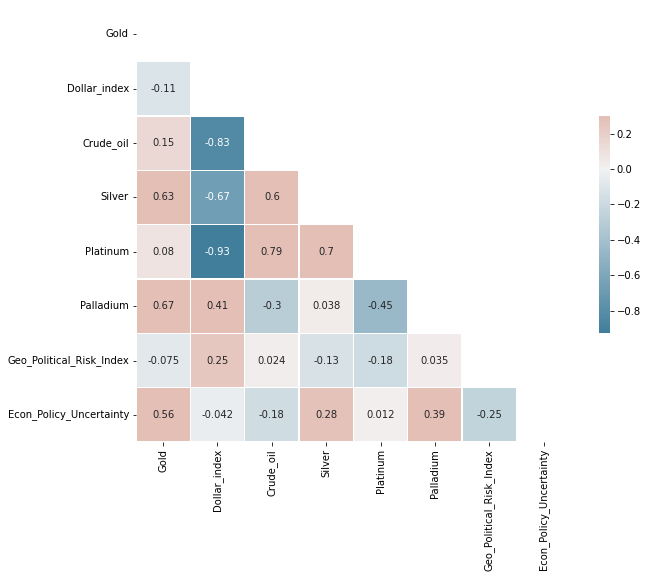

In [ ]:
# Plot correlation matrix heatmap of features(X)
# Below code quoted from: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
def plot_corr_heatmap(df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.gcf().set_size_inches(10, 8)

plot_corr_heatmap(X)

#### Synthetic Dataset

create tabular data with different correlation

# 2. XGB train and test using Synthetic and SHAP_Values

1. Find Acc/Precision/F1 of two XGBClassifer trained by X_train and X_train_S (SHAP value of X_train)

2. Obtain the TreeSHAP explainers of X_input_for_train with different structures. (Synthetic Data)

In [ ]:
import xgboost
from xgboost.sklearn import XGBClassifier
clf = XGBClassifier(eval_metric='auc')

import shap
import warnings
warnings.filterwarnings("ignore")

def find_acc_precision_f1(X_test, y_test, clf, round_dig=4):
  a = metrics.accuracy_score(y_test, clf.predict(X_test)).round(round_dig)
  b = metrics.precision_score(y_test, clf.predict(X_test)).round(round_dig)
  c = metrics.f1_score(y_test, clf.predict(X_test)).round(round_dig)
  return [a, b, c]

In [ ]:
# XGB - Original Data Input to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
XGB_1 = clf.fit(X_train, y_train)


# TREE SHAP_Explainer
explainer = shap.TreeExplainer(XGB_1)
#exp_stru1 = shap.TreeExplainer(clf.fit(X_train, y_train))   # clf - synthetic train data 1
#exp_stru1 = shap.TreeExplainer(clf.fit(X_train, y_train))   # clf - synthetic train data 2


# XGB - SHAP Value input to train
shap_values = explainer.shap_values(X)
shap_X = pd.DataFrame(shap_values, columns=df.columns[:8])
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(shap_X, y, test_size=0.2)

XGB_shap = clf.fit(X_train_S, y_train_S)

In [ ]:
Synthetic_acc = 0

# compare accuracy of models using different input train data
print("Model Prediction Using: \n. Original Input = {} \n. Synthetic Input = {} \n. SHAP Input = {}".format(find_acc_precision_f1(X_test, y_test, XGB_1),
                                                                                                            Synthetic_acc,
                                                                                                            find_acc_precision_f1(X_test_S, y_test_S, XGB_shap)))

Model Prediction Using: 
. Original Input = [0.5, 0.5, 0.6667] 
. Synthetic Input = 0 
. SHAP Input = [0.9333, 1.0, 0.9286]


讲实话，SHAP value increase accurcay 的原因应该是numerically, the calculation is easier to round

While the X_train includes value count in unit:thousand, most SHAP values are relatively too small

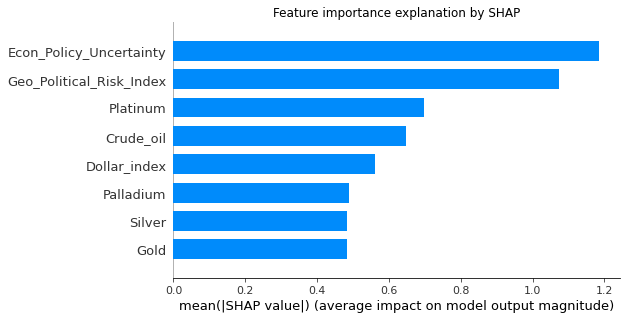

In [ ]:
plt.title("Feature importance explanation by SHAP")
shap.summary_plot(shap_values, shap.sample(X_test), plot_type="bar", show=True)

In [ ]:
# 2. Structure_I_sythetic data

# 3. Structure_II_synthetic data

# 4. Need to write own interactive plots API

1. Design the plot you want 

2. Design the API and write it 

In [ ]:
# D3
# Altair
# Streamlit
# 4 python interactive timeseries plots: https://towardsdatascience.com/top-4-python-libraries-to-build-interactive-timeseries-plots-f2214cc9b1ea